In [11]:
import json
from ToolFunc import scaleRegions, objective, AABBCollision, Distance
from scipy.optimize import basinhopping, dual_annealing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
import copy

def optimization(info, weight, penalty_record):
    # print("=====================", info, "+++++++++++++++++++++++++")
    BBOX_SIZE = (150, 300)
    polys = copy.deepcopy(info["regions"])
    TARGET_C = copy.deepcopy(info["insights"])
    MIN_C, MIN_SCORE = [], []
    for t in range(0, len(TARGET_C)):
        # define the bounds on the search
        bounds = [[0, info["width"] - BBOX_SIZE[0]], [0, info["height"] - BBOX_SIZE[1]]]
        # perform the simulated annealing search
        # x0 = [TARGET_C[t][0], TARGET_C[t][1]]
        x0 = np.asarray([0, 0])
        
        result = dual_annealing(
            # objective, bounds, x0=x0, args=(polys, TARGET_C[t], BBOX_SIZE)
            objective,
            bounds,
            x0=x0,
            args=(polys, TARGET_C[t], BBOX_SIZE),
        )
        
        # print("=====================", result, "+++++++++++++++++++++++++")
        # # summarize the result
        # print("Status : %s" % result["message"])
        # print("Total Evaluations: %d" % result["nfev"])
        # evaluate solution
        solution = list(result["x"])
        evaluation = objective(solution, polys, TARGET_C[t], BBOX_SIZE)
        # print("Solution: f(%s) = %.5f" % (solution, evaluation))
        print("Solution: f(%s) = %f" % (solution, evaluation))
        AnnoBox = {
            "x": solution[0],
            "y": solution[1],
            "w": BBOX_SIZE[0],
            "h": BBOX_SIZE[1],
        }
        print(
            "AABB: ",
            AABBCollision(AnnoBox, polys) * 0.6,
            "Dis:",
            Distance(AnnoBox, TARGET_C[t]) * 0.4,
        )
        penalty_record[t] = {}
        penalty_record[t]["AABB"] = AABBCollision(AnnoBox, polys) * 0.6
        # draw["AABB"].append(AABBCollision(AnnoBox, polys) * 0.6)
        penalty_record[t]["dis"] = Distance(AnnoBox, TARGET_C[t]) * 0.4
        # draw["Distance"].append(Distance(AnnoBox, TARGET_C[t]) * 0.4)
        # solution_c = (solution[0] + BBOX_SIZE[0] / 2, solution[1] + BBOX_SIZE[1] / 2)
        solution_c = (solution[0], solution[1])

        MIN_C.append(solution_c)
        MIN_SCORE.append(evaluation)
        polys.append(
            {
                "points": [solution[0], solution[1], BBOX_SIZE[0], BBOX_SIZE[1]],
                "alpha": weight,
            }
        )
    # print("=====================", MIN_C, MIN_SCORE, "+++++++++++++++++++++++++")
    return MIN_C, MIN_SCORE

# def optimization(info, weight, penalty_record, draw):
    # print("=====================", info, "+++++++++++++++++++++++++")
    BBOX_SIZE = (150, 300)
    polys = copy.deepcopy(info["regions"])
    TARGET_C = copy.deepcopy(info["insights"])
    MIN_C, MIN_SCORE = [], []
    # print('fixed:', polys[0]['points'])
    for t in range(0, len(TARGET_C)):
        # define the bounds on the search
        bounds = [[0, info["width"] - BBOX_SIZE[0]], [0, info["height"] - BBOX_SIZE[1]]]
        # perform the simulated annealing search
        # x0 = [TARGET_C[t][0], TARGET_C[t][1]]
        x0 = np.asarray([0, 0])
        # print('fixed', TARGET_C[t])
        
        result = dual_annealing(
            # objective, bounds, x0=x0, args=(polys, TARGET_C[t], BBOX_SIZE)
            objective,
            bounds,
            x0=x0,
            args=(polys, TARGET_C[t], BBOX_SIZE),
        )
        
        # print("=====================", result, "+++++++++++++++++++++++++")
        # # summarize the result
        # print("Status : %s" % result["message"])
        # print("Total Evaluations: %d" % result["nfev"])
        # evaluate solution
        solution = list(result["x"])
        evaluation = objective(solution, polys, TARGET_C[t], BBOX_SIZE)
        print("Solution: f(%s) = %.5f" % (solution, evaluation))
        AnnoBox = {
            "x": solution[0],
            "y": solution[1],
            "w": BBOX_SIZE[0],
            "h": BBOX_SIZE[1],
        }
        print(
            "AABB: ",
            AABBCollision(AnnoBox, polys) * 0.6,
            "Dis:",
            Distance(AnnoBox, TARGET_C[t]) * 0.4,
        )
        penalty_record[t] = {}
        penalty_record[t]["AABB"] = AABBCollision(AnnoBox, polys) * 0.6
        draw["AABB"].append(AABBCollision(AnnoBox, polys) * 0.6)
        penalty_record[t]["dis"] = Distance(AnnoBox, TARGET_C[t]) * 0.4
        draw["Distance"].append(Distance(AnnoBox, TARGET_C[t]) * 0.4)
        solution_c = (solution[0] + BBOX_SIZE[0] / 2, solution[1] + BBOX_SIZE[1] / 2)

        MIN_C.append(solution_c)
        MIN_SCORE.append(evaluation)
        polys.append(
            {
                "points": [solution[0], solution[1], BBOX_SIZE[0], BBOX_SIZE[1]],
                "alpha": weight,
            }
        )
    # print('fixed2:', polys[0]['points'])
    # print("=====================", MIN_C, MIN_SCORE, "+++++++++++++++++++++++++")
    return MIN_C, MIN_SCORE

def scale_objective(scale, weight, canvas_info, save_info_scale):
    origin_info = {
        "shape_regions": [],
        "alpha_regions": [],
        "insights": copy.deepcopy(canvas_info["insights"]),
    }

    for i in range(0, len(canvas_info["regions"])):
        origin_info["shape_regions"].append(copy.deepcopy(canvas_info["regions"][i]["points"]))
        origin_info["alpha_regions"].append(copy.deepcopy(canvas_info["regions"][i]["alpha"]))
    print("++++++++", str(scale[0]))
    scaling = scale[0]
    info_scale = scaleRegions(
        canvas_info["width"], canvas_info["height"], origin_info, scaling
    )
    save_info_scale["scale_" + str(scaling)] = {"info": info_scale}
    save_info_scale["scale_" + str(scaling)]["penalty"] = {}
    # MIN_C, MIN_SCORE = find_leaf_placement(info_scale, weight)
    MIN_C, MIN_SCORE = optimization(
        info_scale, weight, save_info_scale["scale_" + str(scaling)]["penalty"]
    )
    min_score = sum(MIN_SCORE)
    print("score: ", sum(MIN_SCORE))
    # for multiple insights, put it to the "smallest penalty" insight
    # min_c = MIN_C[np.argmin(MIN_SCORE)]
    save_info_scale["scale_" + str(scaling)]["center"] = MIN_C
    save_info_scale["scale_" + str(scaling)]["score"] = MIN_SCORE
    # draw["all"].append(sum(MIN_SCORE))
    # draw["scale"].append(scaling)
    # draw["place"].append(MIN_C)
    return min_score

# def scale_objective(scale, weight, canvas_info, save_info_scale, draw):
    origin_info = {
        "shape_regions": [],
        "alpha_regions": [],
        "insights": copy.deepcopy(canvas_info["insights"]),
    }

    for i in range(0, len(canvas_info["regions"])):
        origin_info["shape_regions"].append(copy.deepcopy(canvas_info["regions"][i]["points"]))
        origin_info["alpha_regions"].append(copy.deepcopy(canvas_info["regions"][i]["alpha"]))
    print("++++++++", scale)
    scaling = scale[0]
    print('fixed',origin_info["shape_regions"][0])
    info_scale = scaleRegions(
        canvas_info["width"], canvas_info["height"], origin_info, scaling
    )
    save_info_scale["scale_" + str(scaling)] = {"info": info_scale}
    save_info_scale["scale_" + str(scaling)]["penalty"] = {}
    print('fixed2',origin_info["shape_regions"][0])
    # MIN_C, MIN_SCORE = find_leaf_placement(info_scale, weight)
    MIN_C, MIN_SCORE = optimization(
        info_scale, weight, save_info_scale["scale_" + str(scaling)]["penalty"], draw
    )
    min_score = sum(MIN_SCORE)
    print("score: ", sum(MIN_SCORE))
    # for multiple insights, put it to the "smallest penalty" insight
    # min_c = MIN_C[np.argmin(MIN_SCORE)]
    save_info_scale["scale_" + str(scaling)]["center"] = MIN_C
    save_info_scale["scale_" + str(scaling)]["score"] = MIN_SCORE
    draw["all"].append(sum(MIN_SCORE))
    draw["scale"].append(scaling)
    draw["place"].append(MIN_C)
    return min_score

    # continuous attempt

def optimal_scale_placement(canvas_info, weight):
    print("optimal scale placement")
    print(canvas_info)
    # print(weight)
    save_info_scale = {}

    # initial state 0.9, give bound of 0.8, 1.0 and find global minimum in bound
    x0 = [0.9]
    minimizer_kwargs = dict(
        method="L-BFGS-B",
        bounds=[(0.8, 1.0)],
        tol=1e-3,
        args=(weight, canvas_info, save_info_scale),
    )
    
    # basin hopping: Find the global minimum of a objective function using the basin-hopping algorithm.
    result = basinhopping(
        scale_objective,
        x0,
        minimizer_kwargs=minimizer_kwargs,
        stepsize=0.25,
        niter=20,
        niter_success=2,
    )
    # print("global minimum: x = %.4f, f(x) = %.4f" % (result.x, result.fun))
    print("global minimum: x = %f, f(x) = %f" % (result.x, result.fun))
    # return best_scale, best_scale_pos
    print("++++++++++++", save_info_scale)
    # with open("info_scale.json", "w", encoding="utf-8") as f:
    #     json.dump(save_info_scale, f, ensure_ascii=False, indent=4)
    # try it 12/14/2022
    # result.x[0] = int(result.x[0])
    print(result.x)
    print("type(result.x): ", type(result.x))
    print("type: ", type(save_info_scale["scale_" + str(result.x[0])]["center"]))
    return result.x[0], save_info_scale["scale_" + str(result.x[0])]["center"]


# def optimal_scale_placement(canvas_info, weight, draw):
#     save_info_scale = {}

#     # initial state 0.9, give bound of 0.8, 1.0 and find global minimum in bound
#     x0 = [0.9]
#     minimizer_kwargs = dict(
#         method="L-BFGS-B",
#         bounds=[(0.8, 1.0)],
#         tol=1e-3,
#         args=(weight, canvas_info, save_info_scale, draw,),
#     )
    
#     # basin hopping: Find the global minimum of a objective function using the basin-hopping algorithm.
#     result = basinhopping(
#         scale_objective,
#         x0,
#         minimizer_kwargs=minimizer_kwargs,
#         stepsize=0.25,
#         niter=20,
#         niter_success=2,
#     )
#     print("global minimum: x = %.4f, f(x) = %.4f" % (result.x, result.fun))
#     # return best_scale, best_scale_pos
#     # print("++++++++++++", save_info_scale["scale_"+str(result.x[0])])
#     with open("info_scale.json", "w", encoding="utf-8") as f:
#         json.dump(save_info_scale, f, ensure_ascii=False, indent=4)
#     return result.x[0], save_info_scale["scale_" + str(result.x[0])]["center"]

# def optimal_scale_placement(canvas_info, weight, draw):
    save_info_scale = {}
    scale_hyperparam = [1, 0.95, 0.9, 0.85, 0.8]

    best_score, best_scale, best_scale_pos = float("inf"), 1, None
    origin_info = {
        "shape_regions": [],
        "alpha_regions": [],
        "insights": canvas_info["insights"],
    }

    for i in range(0, len(canvas_info["regions"])):
        origin_info["shape_regions"].append(canvas_info["regions"][i]["points"])
        origin_info["alpha_regions"].append(canvas_info["regions"][i]["alpha"])

    for scaling in scale_hyperparam:
        print("scale: ", scaling)
        info_scale = tool.scaleRegions(
            canvas_info["width"], canvas_info["height"], origin_info, scaling
        )
        save_info_scale["scale_" + str(scaling)] = {"info": info_scale}
        save_info_scale["scale_" + str(scaling)]["penalty"] = {}
        # MIN_C, MIN_SCORE = find_leaf_placement(info_scale, weight)
        MIN_C, MIN_SCORE = tool.optimization(
            info_scale,
            weight,
            save_info_scale["scale_" + str(scaling)]["penalty"],
            draw,
        )

        save_info_scale["scale_" + str(scaling)]["center"] = MIN_C
        save_info_scale["scale_" + str(scaling)]["score"] = MIN_SCORE

        print("scale Penalty:", sum(MIN_SCORE))
        print()
        if sum(MIN_SCORE) * (2 - scaling * scaling) < best_score:
            best_score = sum(MIN_SCORE) * (2 - scaling * scaling)
            best_scale = scaling
            best_scale_pos = MIN_C
        draw["all"].append(sum(MIN_SCORE))
    # print("best: ", best_score)
    with open("old_info_scale.json", "w") as f:
        json.dump(save_info_scale, f)
    # print(MIN_SCORE)

    return best_scale, best_scale_pos



In [21]:
# def test(x, a, b, tried):
#     tried["a"] = 100+a
#     return (x*a)**2 - 2*a*b*x + b**2
# x0 = 5
# a = 5
# b = 10
# tried={"a":0}
# minimizer_kwargs = dict(
#         method="L-BFGS-B",
#         bounds=[(0, 10)],
#         tol=1e-3,
#         args=(a, b, tried),
#     )
# result = basinhopping(
#         test,
#         x0,
#         minimizer_kwargs=minimizer_kwargs,
#         stepsize=0.25,
#         niter=20,
#         niter_success=2,
#     )
# print(a, b, tried)
# print("global minimum: x = %.4f, f(x) = %.4f" % (result.x, result.fun))

5 10 {'a': 105}
global minimum: x = 2.0000, f(x) = 0.0000


In [12]:
# Opening JSON file
f = open("canvas.json")

# returns JSON object as
# a dictionary
data = json.load(f)

weight = 1
canvas_info = data
draw = {"all": [], "AABB": [], "Distance": [], "AABB_draw": [], "Dis_draw": [], 'scale': [], 'place': []}
print(optimal_scale_placement(canvas_info, weight))

optimal scale placement
{'width': 929, 'height': 490, 'regions': [{'points': [132.5, 83.5, 60, 343], 'alpha': 1}, {'points': [408.5, 262.5, 60, 164], 'alpha': 0.5}, {'points': [683.5, 408.5, 60, 18], 'alpha': 0.5}, {'points': [187.5, 356.5, 60, 70], 'alpha': 0.5}, {'points': [463.5, 333.5, 60, 93], 'alpha': 1}, {'points': [738.5, 414.5, 60, 12], 'alpha': 0.5}, {'points': [243.5, 426.5, 59, 0], 'alpha': 0.5}, {'points': [518.5, 424.5, 60, 2], 'alpha': 0.5}, {'points': [793.5, 423.5, 60, 3], 'alpha': 1}, {'points': [467.783203125, 468.25, 78.43359375, 21.75], 'alpha': 0.5}, {'points': [20, 183.640625, 21.75, 107.71875], 'alpha': 0.5}, {'points': [266.234375, 10, 407.53125, 18], 'alpha': 0.5}, {'points': [409.515625, 10, 115.70700073242188, 18], 'alpha': 0.5}, {'points': [540.22265625, 10, 133.54302978515625, 18], 'alpha': 0.5}], 'insights': [[162.5, 83.5], [493.5, 333.5], [823.5, 423.5]]}
++++++++ 0.9
Solution: f([264.09999999118173, 49.70002199313213]) = 41.510571
AABB:  6.6555336609999

In [34]:
for i in canvas_info["regions"]:
    print(i)

{'points': [127.5, 77.5, 51, 288], 'alpha': 1}
{'points': [364.5, 228.5, 51, 137], 'alpha': 0.5}
{'points': [600.5, 350.5, 52, 15], 'alpha': 0.5}
{'points': [174.5, 306.5, 52, 59], 'alpha': 0.5}
{'points': [411.5, 287.5, 51, 78], 'alpha': 1}
{'points': [648.5, 355.5, 51, 10], 'alpha': 0.5}
{'points': [222.5, 365.5, 51, 0], 'alpha': 0.5}
{'points': [458.5, 364.5, 52, 1], 'alpha': 0.5}
{'points': [695.5, 363.5, 51, 2], 'alpha': 1}
{'points': [409.7864990234375, 407.00001525878906, 78.42708587646484, 22], 'alpha': 0.5}
{'points': [20, 153.14064025878906, 22, 107.71875], 'alpha': 0.5}
{'points': [208.23956298828125, 10, 407.5208435058594, 18], 'alpha': 0.5}
{'points': [351.5103759765625, 10, 115.70833587646484, 18], 'alpha': 0.5}
{'points': [482.21875, 10, 133.5416717529297, 18], 'alpha': 0.5}


In [ ]:
# for place in range(len(draw['place'])):
#     # fig = plt.figure()
#     # ax = fig.add_subplot(111)
#     fig, ax = plt.subplots()
#     ax.plot([0, canvas_info["width"]], [0, canvas_info["height"]])
#     for i in canvas_info["regions"]:
#         # print(
#         #     (i["points"][0], i["points"][1]),
#         #     i["points"][2],
#         #     i["points"][3],
#         # )
#         rect = patches.Rectangle(
#             (i["points"][0], i["points"][1]),
#             i["points"][2],
#             i["points"][3],
#         )
#         ax.add_patch(rect)
#     plt.title(str('scale: '+str(draw['scale'][place])))
#     plt.xlim([0, canvas_info["width"]])
#     plt.ylim([0, canvas_info["height"]])
#     plt.gca().invert_yaxis()
#     plt.show()

In [69]:
for place in range(len(draw['place'])):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # fig, ax = plt.subplots()
    # ax.plot([0, canvas_info["width"]], [0, canvas_info["height"]])
    for i in canvas_info["regions"]:
        # print(
        #     (i["points"][0], i["points"][1]),
        #     i["points"][2],
        #     i["points"][3],
        # )
        rect = patches.Rectangle(
            (i["points"][0], i["points"][1]),
            i["points"][2],
            i["points"][3],
        )
        ax.add_patch(rect)
    for i in range(len(draw['place'][place])):
        # print(i)
        rect = patches.Rectangle(
            (draw['place'][place][i][0]-150/2, draw['place'][place][i][1]-300/2),
            150,
            300,
            facecolor = 'none',
            edgecolor = 'red'
        )
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(str(i), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

    plt.title(str('scale: '+str(draw['scale'][place])))
    plt.xlim([0, canvas_info["width"]])
    plt.ylim([0, canvas_info["height"]])
    plt.gca().invert_yaxis()
    # plt.show()
    plt.savefig(f'./tmp/{place}.png')
    plt.close()


In [68]:
print(len(draw['place']))

244


In [63]:
# 生成gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for i in range(len(draw['place'])):
        filename = './tmp/'+str(i)+'.png'
        image = imageio.imread(filename)
        writer.append_data(image)

In [71]:
print(len(draw['scale']))

244


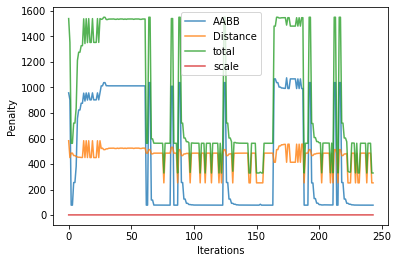

In [72]:
draw["AABB_draw"] = []
draw["Dis_draw"] = []

for i in range(len(draw["all"])):
    draw["AABB_draw"].append(
        draw["AABB"][i * 3] + draw["AABB"][i * 3 + 1] + draw["AABB"][i * 3 + 2]
    )
    draw["Dis_draw"].append(
        draw["Distance"][i * 3]
        + draw["Distance"][i * 3 + 1]
        + draw["Distance"][i * 3 + 2]
    )
draw_x = []
for i in range(len(draw["all"])):
    draw_x.append(i)
# print(draw)
plt.plot(draw_x, draw["AABB_draw"], label="AABB", alpha=0.8)
plt.plot(draw_x, draw["Dis_draw"], label="Distance", alpha=0.8)
plt.plot(draw_x, draw["all"], label="total", alpha=0.8)

leg = plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Penalty")
# plt.ylim([-20, 1850])
plt.show()
f.close()

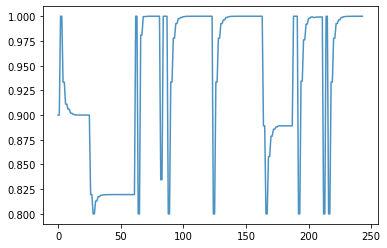

In [73]:
plt.plot(draw_x, draw["scale"], label="scale", alpha=0.8)
plt.show()